In [ ]:
# https://huggingface.co/transformers/model_doc/gpt2.html#transformers.GPT2ForSequenceClassification
# https://gmihaila.github.io/tutorial_notebooks/gpt2_finetune_classification/


from transformers import GPT2ForSequenceClassification

In [2]:
import pandas as pd

In [3]:
reviews = pd.read_csv('../data/reviews.csv')

reviews.shape

(568454, 10)

In [4]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


<AxesSubplot:title={'center':'Histogram of String Length'}, ylabel='Frequency'>

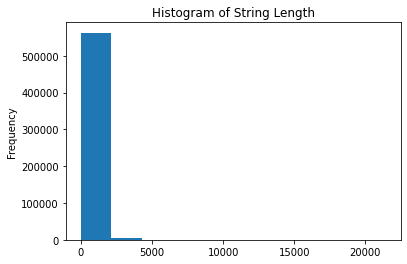

In [5]:
reviews['Text'].str.len().plot(kind='hist', title='Histogram of String Length')

In [6]:
reviews['len'] = reviews['Text'].str.len()
reviews = reviews[reviews['len'] < 150][reviews['len'] > 100]

reviews.shape

<ipython-input-6-de870841e023>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  reviews = reviews[reviews['len'] < 150][reviews['len'] > 100]


(78888, 11)

In [7]:
reviews['Sentiment'] = reviews['Score'].map(lambda x: 'positive'  if x >=  4 else 'negative')

<AxesSubplot:title={'center':'Histogram of String Length'}, ylabel='Frequency'>

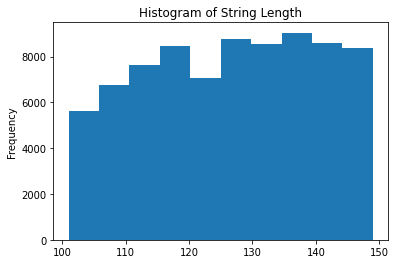

In [8]:
reviews['Text'].str.len().plot(kind='hist', title='Histogram of String Length')

<AxesSubplot:>

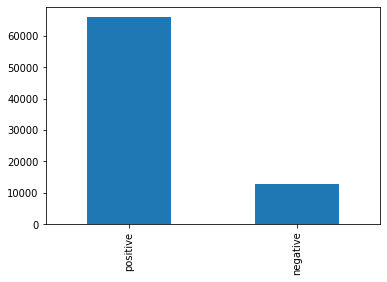

In [9]:
reviews['Sentiment'].value_counts().plot(kind='bar')

In [10]:
reviews_sample = reviews.groupby('Sentiment').sample(500)

reviews_sample.shape

(1000, 12)

In [13]:
from transformers import GPT2Tokenizer

MODEL = 'distilgpt2'

tokenizer = GPT2Tokenizer.from_pretrained(MODEL)

tokenizer.pad_token = tokenizer.eos_token

#add two prompts, one for each task
SENTIMENT_TOKEN = '\nSentiment:'
SUMMARIZE_TOKEN = '\nSummarize:'


# Uncomment these lines to add the two tokens to the tokenizer as brand new tokens

# special_words_to_add={"additional_special_tokens": [SENTIMENT_TOKEN, SUMMARIZE_TOKEN]}
# tokenizer.add_special_tokens(special_words_to_add)


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


<AxesSubplot:>

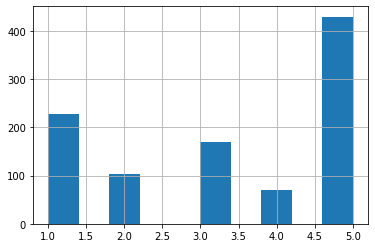

In [14]:
reviews_sample['Score'].hist()

In [15]:
reviews_sample['sentiment_text'] = 'Review: ' + reviews_sample['Text'] + SENTIMENT_TOKEN +  ' ' + reviews_sample['Sentiment'].astype(str)

reviews_sample['summarize_text'] = 'Review: ' + reviews_sample['Text'] + SUMMARIZE_TOKEN +  ' ' + reviews_sample['Summary'].astype(str)


In [16]:
reviews_sample['sentiment_text'].head(2).tolist()

['Review: Another no-ship flower.  There is nothing worse than thinking you have a gift covered only for it to not ship.\nSentiment: negative',
 'Review: I have 4 standard dachsunds and 1 german shepherd and they hated these treats. I gave them away to my local vet.\nSentiment: negative']

In [17]:
tokenizer.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>'}

In [18]:
reviews_sample['summarize_text'].head(2).tolist()

['Review: Another no-ship flower.  There is nothing worse than thinking you have a gift covered only for it to not ship.\nSummarize: Buyer Beware',
 "Review: I have 4 standard dachsunds and 1 german shepherd and they hated these treats. I gave them away to my local vet.\nSummarize: Dogs didn't like"]

In [19]:
# TODO don't repeat utterances

In [20]:
reviews_sample = reviews_sample.sample(frac=1)

In [21]:
mid_point = reviews_sample.shape[0]//2


training_examples = reviews_sample['summarize_text'].head(mid_point).tolist() + reviews_sample['sentiment_text'].tail(mid_point).tolist()



In [22]:
multi_task_df = pd.DataFrame({'text': training_examples})

multi_task_df.shape

(1000, 1)

In [339]:
print(multi_task_df['text'][1])

Review: This just did not live up to our expectations. All three tried it and found the taste only fair and too sweet. Make that 6 thumbs down.
Summarize: Not a hit in our house


In [338]:
print(multi_task_df['text'][800])

Review: Quick delivery and we really like the bold, rich flavor of Green Mountain Dark Magic. This is the way to order K-Cup coffee.
Sentiment: positive


In [23]:
from datasets import Dataset
data = Dataset.from_pandas(multi_task_df)
data

Dataset({
    features: ['text'],
    num_rows: 1000
})

In [24]:
MAX_TOKENS = 256

# texts to numeric vectors of MAX_TOKENS
def tokenize_function(examples):
    # tokenizer created input_ids and attention_mask as output
    output = tokenizer(
        examples['text'],
        add_special_tokens=True,
        max_length=MAX_TOKENS,
        truncation=True,
        padding='max_length',
    )
    
    output['labels'] =  output["input_ids"]
    # -100 is a reserved value to ignore these tokens when calculating the loss
    output["labels"] = [[-100 if x == tokenizer.pad_token_id else x for x in y] for y in output["labels"]]
    return output

data = data.map(
    tokenize_function,
    batched=True,
)
print(data)


  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['attention_mask', 'input_ids', 'labels', 'text'],
    num_rows: 1000
})


In [26]:
data.set_format(type="python", columns=["input_ids", "attention_mask", "labels"])

data = data.train_test_split(test_size=0.20, shuffle=True, seed=0)
print(data)

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'text'],
        num_rows: 800
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'text'],
        num_rows: 200
    })
})


In [27]:
tokenizer.decode(data['train'][0]['input_ids'])

'Review: I love fresh smoked eel, but this stuff is GROSS! Not recommended at all.The oil inside the can is musty and the fish falls apart.\nSummarize: Yuch!<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext

In [28]:
tokenizer.decode([c for c  in data['train'][0]['labels'] if c != -100])

'Review: I love fresh smoked eel, but this stuff is GROSS! Not recommended at all.The oil inside the can is musty and the fish falls apart.\nSummarize: Yuch!'

In [29]:
len(data['train'][0]['input_ids'])

256

In [30]:
len(data['train'][0]['labels'])

256

In [31]:
len(data['train'][0]['attention_mask'])

256

In [32]:
from transformers import Trainer, TrainingArguments
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained(MODEL)

# Update the model embeddings with the new vocabulary size IF we added new special tokens
# model.resize_token_embeddings(len(tokenizer))

model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [33]:
training_args = TrainingArguments(
    output_dir="./gpt2_multitask", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=2, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=32,  # batch size for evaluation
    warmup_steps=50,  # number of warmup steps for learning rate scheduler,
    weight_decay = 0.01,
    logging_steps=5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
)

In [34]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32


{'eval_loss': 4.536126613616943,
 'eval_runtime': 143.5466,
 'eval_samples_per_second': 1.393,
 'eval_steps_per_second': 0.049}

In [35]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running training *****
  Num examples = 800
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 50


Step,Training Loss
5,4.693900
10,4.529500
15,4.417700
20,4.041400
25,3.961600
30,3.822800
35,3.807600
40,3.552100
45,3.533500
50,3.446500




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=50, training_loss=3.9806600189208985, metrics={'train_runtime': 3114.9548, 'train_samples_per_second': 0.514, 'train_steps_per_second': 0.016, 'total_flos': 104518700236800.0, 'train_loss': 3.9806600189208985, 'epoch': 2.0})

In [36]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32


{'eval_loss': 3.444551944732666,
 'eval_runtime': 90.8004,
 'eval_samples_per_second': 2.203,
 'eval_steps_per_second': 0.077,
 'epoch': 2.0}

In [37]:
trainer.save_model()

Saving model checkpoint to ./gpt2_multitask
Configuration saved in ./gpt2_multitask/config.json
Model weights saved in ./gpt2_multitask/pytorch_model.bin


In [282]:
from transformers import pipeline

loaded_model = GPT2LMHeadModel.from_pretrained('./gpt2_multitask')

generator = pipeline(
    'text-generation', model=loaded_model, tokenizer=tokenizer,
    config={'max_length': 200,  'do_sample': False}
)

In [326]:
text_sample, score, summary = reviews_sample.sample(1)[['Text', 'Sentiment', 'Summary']].values[0]

print(text_sample)
print(score)
print(summary)

I live in a small town so it is next to impossible to find decaf k-cups, and even more impossible to find them at this price! Exactly what I wanted!
positive
Yes!!


In [327]:
num_tokens = len(tokenizer(text_sample)['input_ids'])
num_tokens

37

In [328]:
sentiment_text_sample = f'Review: {text_sample}{SENTIMENT_TOKEN}'
summarize_text_sample = f'Review: {text_sample}{SUMMARIZE_TOKEN}'

print(sentiment_text_sample)
print(summarize_text_sample)

Review: I live in a small town so it is next to impossible to find decaf k-cups, and even more impossible to find them at this price! Exactly what I wanted!
Sentiment:
Review: I live in a small town so it is next to impossible to find decaf k-cups, and even more impossible to find them at this price! Exactly what I wanted!
Summarize:


In [329]:
encoded_input = tokenizer(sentiment_text_sample, return_tensors='pt')
    
print(tokenizer.decode(loaded_model.generate(
        input_ids=encoded_input['input_ids'],
        max_length=encoded_input['input_ids'].shape[1] +  1,
        temperature=0.9,
        top_k=2
    )[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Review: I live in a small town so it is next to impossible to find decaf k-cups, and even more impossible to find them at this price! Exactly what I wanted!
Sentiment: positive


In [330]:
encoded_input = tokenizer(summarize_text_sample, return_tensors='pt')
    
print(tokenizer.decode(loaded_model.generate(
        input_ids=encoded_input['input_ids'],
        max_length=len(encoded_input['input_ids']) + 50,
        temperature=0.7,
        beams=5,
        top_k=2,
        no_repeat_ngram_size=2,
    )[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Review: I live in a small town so it is next to impossible to find decaf k-cups, and even more impossible to find them at this price! Exactly what I wanted!
Summarize:   Delicious, delicious and delicious


In [331]:
for generated_text in generator(sentiment_text_sample, num_return_sequences=2, max_length=num_tokens + 10):
    print(generated_text['generated_text'])
    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Review: I live in a small town so it is next to impossible to find decaf k-cups, and even more impossible to find them at this price! Exactly what I wanted!
Sentiment: positive, positive

Review: I live in a small town so it is next to impossible to find decaf k-cups, and even more impossible to find them at this price! Exactly what I wanted!
Sentiment: negative





In [332]:
for generated_text in generator(summarize_text_sample, num_return_sequences=2, max_length=num_tokens + 30):
    print(generated_text['generated_text'])
    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Review: I live in a small town so it is next to impossible to find decaf k-cups, and even more impossible to find them at this price! Exactly what I wanted!
Summarize: Fiery & Not Nutritious! 
Summarize: Fiery & Not Nutritious! 
Review: I live in a small town so it is next to impossible to find decaf k-cups, and even more impossible to find them at this price! Exactly what I wanted!
Summarize:  
Summarize: 
